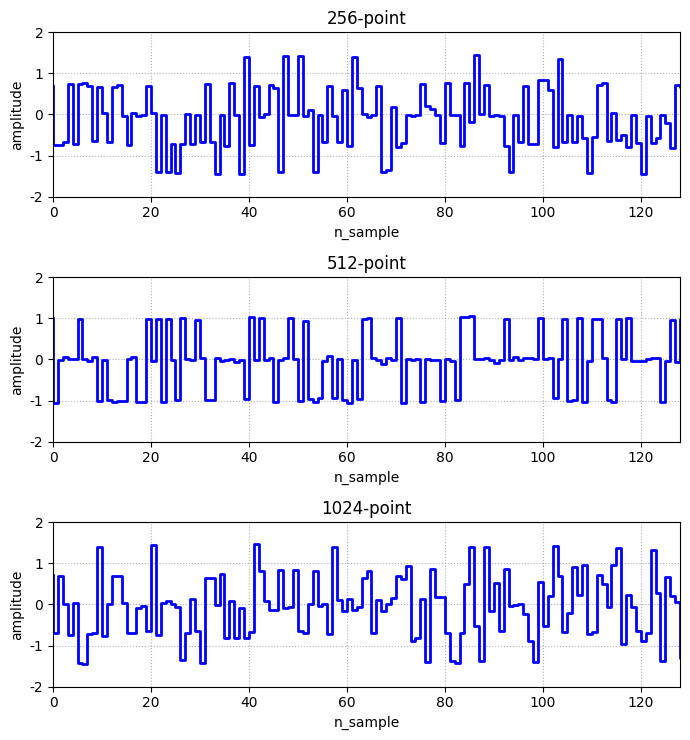

In [74]:
# plot data from ofdm dataset
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from comm.OFDM import OFDM

BASE = '/Users/gtosun/Documents/vsc_workspace/ofdm-amc/data/data_lib/train/24db'

xpaths, ypaths = [], [],
for root, _, files in os.walk(BASE):
    for file in files:
        if file == 'x.npy': xpaths.append(os.path.join(root, file))
        if file == 'y.npy': ypaths.append(os.path.join(root, file))

d = defaultdict(lambda: defaultdict(dict))
for xp, yp in zip(sorted(xpaths), sorted(ypaths)):

    tmp = xp.split('/')
    mod = tmp[10]
    m = tmp[11]
    size = tmp[12]

    d[f'{m}{mod}'][size]['x'] = np.load(xp)
    d[f'{m}{mod}'][size]['y'] = np.load(yp)

frame = d['4psk']['512point']['x'][:, :, 998]
windows = [256, 512, 1024]

filter_bank = [OFDM(n_carriers=n) for n in windows]
t_signals = [filter.demodulate(frame) for filter in filter_bank]


YLIM = 2
nrows, ncols = len(t_signals), 1
fig, axs  = plt.subplots(nrows, ncols)
for ax, t, w in zip(axs, t_signals, windows):
    ax.step(range(len(t[0,:])), t[0,:], "b", linewidth=2)
    ax.set_xlim(left=0, right=128)
    ax.set_xlabel("n_sample")
    ax.set_ylim(bottom=-YLIM, top=YLIM)
    ax.set_ylabel("amplitude")
    ax.set_title(f"{w}-point")

    ax.set_yticks(range(-YLIM, YLIM+1, 1))
    ax.set_yticklabels(range(-YLIM, YLIM+1, 1))

    ax.grid(True, linestyle="dotted")

fig.set_size_inches(ncols * 7, nrows * 2.5)
fig.tight_layout()


filepath = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/filterbank-output"
# fig.savefig(filepath, bbox_inches="tight")

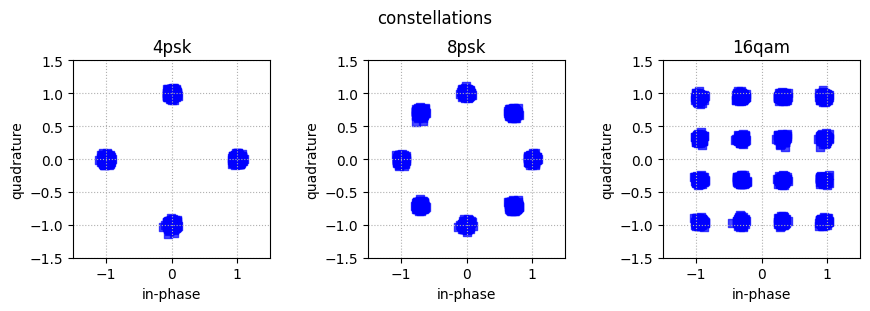

In [78]:
# plot constellations from dataset 
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt

from comm.OFDM import OFDM

BASE = '/Users/gtosun/Documents/vsc_workspace/ofdm-amc/data/data_lib/test/24db'

xpaths, ypaths = [], [],
for root, _, files in os.walk(BASE):
    for file in files:
        if root.endswith("256point"):
            if file == 'x.npy': xpaths.append(os.path.join(root, file))
            if file == 'y.npy': ypaths.append(os.path.join(root, file))


d = defaultdict(lambda: dict())
for xp, yp in zip(sorted(xpaths), sorted(ypaths)):

    tmp = xp.split('/')
    m = tmp[-3]
    mod = tmp[-4]

    d[f'{m}{mod}']['x'] = np.load(xp)
    d[f'{m}{mod}']['y'] = np.load(yp)

mods = ["4psk", "8psk", "16qam",]
label_dict = {i: mod for i, mod in enumerate(mods)}

ks = list(d.keys())
num_types = len(ks)

nrows = 1
ncols = 3

filter = OFDM(n_carriers=256)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

for k, ax in zip(d.keys(), axs):
        x = d[k]['x'][:, :, 0]
        x = filter.demodulate(x)
        xi, xq = x[0, :], x[1, :]

        y = d[k]['y'][0]
        _, idx = torch.max(torch.squeeze(torch.Tensor(d[k]['y'][0])), 0)
    
        ax.set_title(label_dict[idx.item()])
        ax.scatter(xi, xq, marker='s', c='blue', alpha=0.7)
        ax.set_xlim(left=-1.5, right=1.5)
        ax.set_xlabel("in-phase")
        ax.set_ylim(bottom=-1.5, top=1.5)
        ax.set_ylabel("quadrature")
        ax.set_aspect('equal')
        ax.margins(0)
        ax.grid(True, linestyle="dotted")

fig.set_size_inches(w=ncols * 3, h=nrows * 3)
fig.suptitle('constellations')
fig.tight_layout()

filepath = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/constellations"
# fig.savefig(filepath, bbox_inches="tight")

In [ ]:
# train main model

import torch
import numpy as np
from model.AMCModel import AMCModel
from data.dataset.OFDMDataset import OFDMDataset, get_dataloaders
from torch.optim import Adam
import torch.nn as nn

LR = 0.0001
BATCH_SIZE = 1
SHUFFLE = True
EPOCHS = 3

dataset = OFDMDataset()
trainloader, testloader = get_dataloaders(dataset=dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

model = AMCModel()
model = model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=LR)

n_total_steps = len(trainloader)
losses = []
predictions = []

for epoch in range(EPOCHS):
    model = model.train()
    batch_losses = list()
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        scores = model(x)
        loss = criterion(scores, torch.squeeze(y))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        predictions.append(torch.argmax(scores).item())

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {np.mean(batch_losses):.4f}')
            losses.append(np.mean(batch_losses))
            batch_losses.clear()

    model = model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for x, y in testloader: 
            scores = model.forward(x)
            predicted = torch.argmax(scores).item()
            labels = torch.argmax(torch.squeeze(y)).item()
            n_samples += y.size(0)
            n_correct += predicted == labels

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test set: {acc} %')

In [ ]:
# save model

import os
import datetime

date = datetime.date.today().strftime("%Y%m%d")
filename = f"model_baseline__{date}.pth"
write_path = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models"
filepath = os.path.join(write_path, filename)
torch.save(model.state_dict(), filepath)

In [ ]:
# train baseline model

import torch
import numpy as np
from model_baseline.AMCModelBaseline import AMCModelBaseline
from data.dataset.OFDMDataset import OFDMDataset, get_dataloaders
from torch.optim import Adam
import torch.nn as nn

LR = 0.0005
BATCH_SIZE = 1
SHUFFLE = True
EPOCHS = 3

dataset = OFDMDataset()
trainloader, testloader = get_dataloaders(dataset=dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

model = AMCModelBaseline()
model = model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=LR)

n_total_steps = len(trainloader)
losses = []
predictions = []

for epoch in range(EPOCHS):
    model = model.train()
    batch_losses = list()
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        scores = model(x)
        loss = criterion(scores, torch.squeeze(y))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        predictions.append(torch.argmax(scores).item())

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {np.mean(batch_losses):.4f}')
            losses.append(np.mean(batch_losses))
            batch_losses.clear()

    model = model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for x, y in testloader: 
            scores = model.forward(x)
            predicted = torch.argmax(scores).item()
            labels = torch.argmax(torch.squeeze(y)).item()
            n_samples += y.size(0)
            n_correct += predicted == labels

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test set: {acc} %')

In [ ]:
# generate json containing accuracies and confusion matrices
from test.Test import Test

WRITE_DIR = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test"
MODEL_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models/model_alternative__20231226.pth"
MODEL_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models/model_baseline__20231226.pth"

t = Test(MODEL_PATH, WRITE_DIR)
t.run()

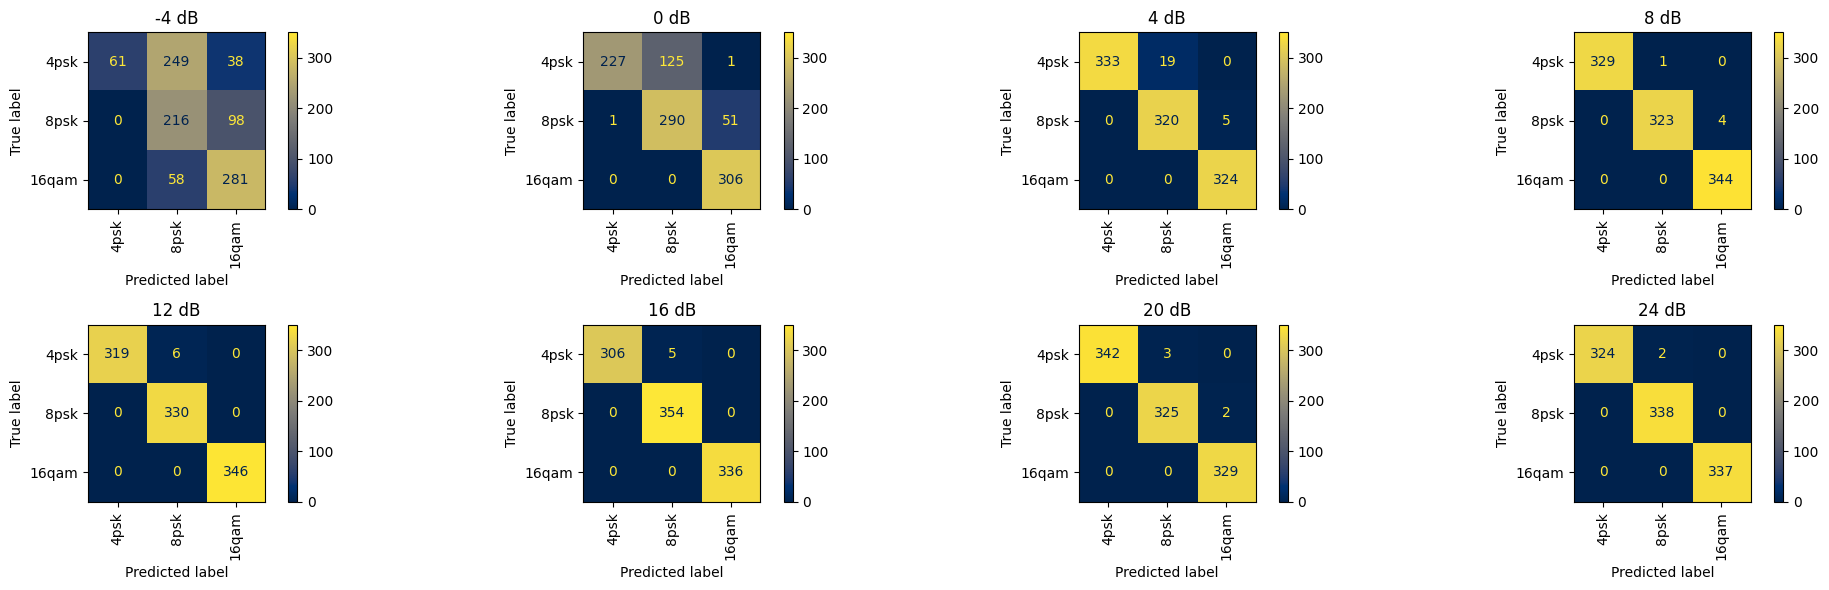

In [83]:
# plot and save confusion matrices
import json

from datetime import datetime as dt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.style.use("default")

STATS_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModelBaseline__20231226.json"
STATS_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModel__20231226.json"
MODEL_TYPE = STATS_PATH.split("/")[-1].split("__")[1]
WRITE_DIR = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test"
with open(file=STATS_PATH, mode="r") as f:
    model_stats = json.load(f)

cm = dict()
for k in model_stats["train"].keys():
    cm[k] = np.array(model_stats["train"][k]["conf_matrix"]).T

item_cnt = len(cm.keys())
nrows = 2
ncols = (item_cnt+1) // nrows

fig, axs = plt.subplots(nrows, ncols)
for snr_str, ax in zip(cm.keys(), axs.flatten()):
    disp = ConfusionMatrixDisplay(
        cm[snr_str],
        display_labels=["4psk", "8psk", "16qam"]
        ).plot(ax=ax, cmap="cividis", xticks_rotation="vertical")
    disp.ax_.get_images()[0].set_clim(0, 350)
    ax.set_title(f"{snr_str} dB")
    ax.margins(0)

# fig.suptitle(f"Confusion Matrices for {MODEL_TYPE}")
fig.set_size_inches(ncols * 5, nrows * 3)
fig.tight_layout()

date = dt.today().strftime("%Y%m%d")
filepath = f"{WRITE_DIR}/cmatrix__{MODEL_TYPE}__{date}_1"
# fig.savefig(filepath, bbox_inches='tight')

In [84]:
# generate snr vs accuracy maps
import json

MODEL_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModel__20231226.json"
MODEL_BASELINE_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModelBaseline__20231226.json"
with open(file=MODEL_PATH) as fp:
    model_stats = json.load(fp)

with open(file=MODEL_BASELINE_PATH) as fp:
    model_baseline_stats = json.load(fp)

snr_acc_map_model = {int(snr_val): model_stats["test"][snr_val]["accuracy"] for snr_val in model_stats["test"]}
snr_acc_map_baseline = {int(snr_val): model_baseline_stats["test"][snr_val]["accuracy"] for snr_val in model_baseline_stats["test"]}

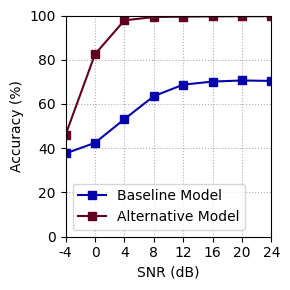

In [85]:
# plot snr vs accuracy and save

import datetime
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict

nrows = 1
ncols = 1
snr_vals = list(snr_acc_map_baseline.keys())

fig, axs = plt.subplots(nrows, ncols)

def _draw(ax: plt.Axes, data: np.array, args: Dict[str, Any]) -> None:
    ax.plot([100*x for x in data], marker="s", **args)
    ax.grid(linestyle="dotted")
    ax.margins(0)

    ax.set_xlabel("SNR (dB)")
    ax.set_xticks(range(len(snr_vals)))
    ax.set_xticklabels((snr_vals))

    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim((0,100))
    ax.set_aspect("auto")

    ax.legend()

_draw(axs, list(snr_acc_map_baseline.values()), {"label":"Baseline Model" ,   "color":"xkcd:royal blue"})
_draw(axs, list(snr_acc_map_model.values()),    {"label":"Alternative Model", "color": "xkcd:burgundy"})
fig.set_size_inches(w=3, h=3)
fig.tight_layout()

date = datetime.datetime.today().strftime("%Y%m%d")
# fig.savefig(f"/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/snr_acc_{date}.png")

In [ ]:
import os
import datetime
from tqdm import tqdm
from typing import Dict, Union

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

from model.AMCModel import AMCModel
from model_baseline.AMCModelBaseline import AMCModelBaseline
from data.dataset.OFDMDataset import OFDMDataset, get_dataloader

MODEL_ALT_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models/model_alternative__20231226.pth"
MODEL_BSE_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models/model_baseline__20231226.pth"

# get dataset
dataset = OFDMDataset(is_training=False)
test_loader = get_dataloader(dataset, batch_size=1, shuffle=True)

# load base model
base_model = AMCModelBaseline()
base_model.load_state_dict(torch.load(MODEL_BSE_PATH))
base_model.eval()

# load alternative model
alt_model = AMCModel()
alt_model.load_state_dict(torch.load(MODEL_ALT_PATH))
alt_model.eval()


# get predictions for both models

# init arrays
n           = len(test_loader)
true        = [0] * n
base_pred   = [{0: .0, 1: .0, 2: .0} for _ in range(n)]
alt_pred    = [{0: .0, 1: .0, 2: .0} for _ in range(n)]

# loop over test set
for i, (x, y) in enumerate(tqdm(test_loader)):
    true[i] = torch.argmax(y).item()

    # predictions for base model
    scores = base_model.forward(x)
    scores = torch.softmax(scores, dim=0)
    idx = torch.argmax(scores).item()
    score = scores[idx].item()

    sc = scores.detach()
    base_pred[i] = {i: sc[i].item() for i in range(len(sc))}

    # predictions for alt model
    scores = alt_model.forward(x)
    scores = torch.softmax(scores, dim=0)
    idx = torch.argmax(scores).item()
    score = scores[idx].item()

    sc = scores.detach()
    alt_pred[i] = {i: sc[i].item() for i in range(len(sc))}

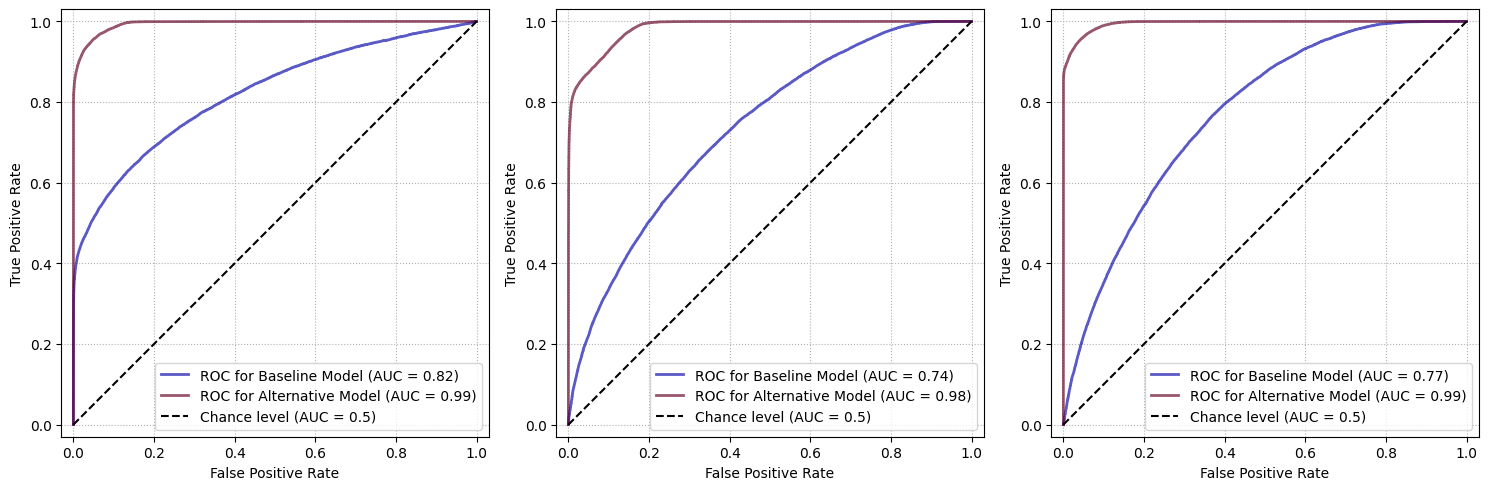

In [7]:
def _draw_for_class(ax: plt.Axes, target_class: int, base_args: Dict[str, Union[str, int, float]], alt_args: Dict[str, Union[str, int, float]]):
    
    target_true      = [1 if label==target_class else 0 for label in true]
    target_base_pred = [pred[target_class] for pred in base_pred]
    target_alt_pred  = [pred[target_class] for pred in alt_pred]

    RocCurveDisplay.from_predictions(
        name="ROC for Baseline Model",
        y_true=target_true,
        y_pred=target_base_pred,
        ax=ax,
        **base_args
    )

    RocCurveDisplay.from_predictions(
        name="ROC for Alternative Model",
        y_true=target_true,
        y_pred=target_alt_pred,
        ax=ax,
        plot_chance_level=True,
        chance_level_kw={"color": "black"},
        **alt_args
    )

plt.style.use("default")
nrows, ncols = 1, 3
# nrows, ncols = 3, 1
fig, axs = plt.subplots(nrows,ncols)

for i in range(3):
    ax: plt.Axes = axs[i]
    baseline_args    = {"linewidth": 2, "alpha": 0.66, "color": "xkcd:royal blue"}
    alternative_args = {"linewidth": 2, "alpha": 0.66, "color": "xkcd:burgundy"}

    _draw_for_class(ax, i, baseline_args, alternative_args)

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    ax.margins(0.03)
    ax.set_aspect("equal")
    ax.grid(linestyle="dotted")

fig.set_size_inches(w=ncols*5, h=nrows*5)
fig.tight_layout()

date = datetime.datetime.today().strftime("%Y%m%d")
write_base = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test"
filename = f"roc_per_class__{date}_vert.png"
filepath = os.path.join(write_base, filename)
fig.savefig(filepath, bbox_inches="tight")

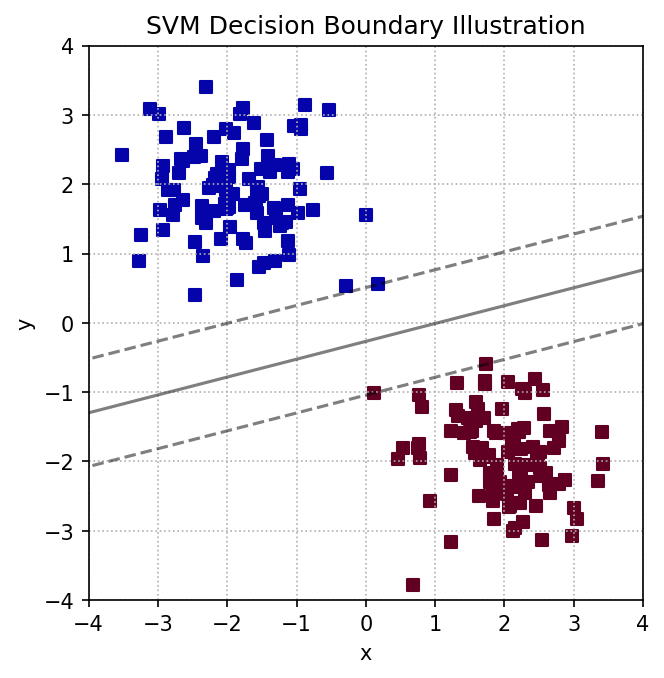

In [4]:
import numpy as np
from typing import Tuple

from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt


N_SAMPLES = 100

CLASS_A_CENTER = (-2, 2)
CLASS_A_SPREAD = 0.5

CLASS_B_CENTER = (2, -2)
CLASS_B_SPREAD = 0.5

def generate_cluster(center: Tuple[int, int], spread: float) -> np.array:
    x = center[0] + np.sqrt(spread) * np.random.randn(N_SAMPLES)
    y = center[1] + np.sqrt(spread) * np.random.randn(N_SAMPLES)
    return np.stack((x, y))


a = generate_cluster(CLASS_A_CENTER, CLASS_A_SPREAD)
b = generate_cluster(CLASS_B_CENTER, CLASS_B_SPREAD)

# train set
X = np.column_stack((a, b)).T
y = np.array([0] * N_SAMPLES + [1] * N_SAMPLES)
model = svm.SVC(kernel="linear")
model.fit(X, y)

fig, ax = plt.subplots(1, 1)
ax.scatter(a[0,:], a[1,:], color="xkcd:royal blue", marker="s")
ax.scatter(b[0,:], b[1,:], color="xkcd:burgundy", marker="s")
ax.grid(True, linestyle="dotted")
ax.margins(0)

ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("SVM Decision Boundary Illustration")
ax.set_aspect("equal")


DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)

fig.set_dpi(150)
fig.savefig("/Users/gtosun/Documents/vsc_workspace/binance-access/svm-illustration.png", format="png", bbox_inches="tight")